# Pix2Pix

**기억할 점**
- **한 도메인에 있는 이미지를 다른 도메인으로 해석해보자**는 관점
- Image to Image Mapping Network에서 Photo-realistic을 추구하고자 함
- GAN의 adverserial을 사용
- U-Net과 PatchGAN 등을 이용해서 성능을 최적화함
- 양쪽 도메인에 대응되는 데이터 쌍이 존재해야 함(반면 cyclegan은 데이터 쌍이 없어도 됨)

## Pix2Pix의 손실함수
- Adverserial Loss

$$L_{cGAN}(G, D) = E_{y\sim p_{data}(y)} \big[\text{log}D(y) \big] + E_{x\sim P_{data}(x), z \sim P_{z}(z)} \big[\| y - G(x, z) \|_{1}\big]$$


- Reconstruction Loss

$$L_{L1}\big(G \big) = E_{x, y \sim P_{data}(x, y), z \sim p_{z}(z)} \big[ \| y - G(x, z) \|_{1} \big]$$

- Total Loss

$$G^{*} = arg \underset{G}{\operatorname{min}} \underset{D}{\operatorname{max}} L_{cGAN}(G, D) + \lambda L_{L1}(G)$$

## 1. Import Libs

In [1]:
from __future__ import print_function
import argparse
import os
from math import log10

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from networks import define_G, define_D, GANLoss, print_network
from data import get_training_set, get_test_set
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

## 2. Setting Hyperparameters

In [2]:
parser = argparse.ArgumentParser(description='pix2pix-PyTorch-implementation')
parser.add_argument('--dataset', required=False, default='facades',help='facades')
parser.add_argument('--batchSize', type=int, default=4, help='training batch size')
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--nEpochs', type=int, default=40, help='number of epochs to train for')
parser.add_argument('--input_nc', type=int, default=3, help='input image channels')
parser.add_argument('--output_nc', type=int, default=3, help='output image channels')
parser.add_argument('--ngf', type=int, default=64, help='generator filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='discriminator filters in first conv layer')
parser.add_argument('--lr', type=float, default=0.001, help='Learning Rate. Default=0.002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--lamb', type=int, default=10, help='weight on L1 term in objective')
params = parser.parse_args([])

print(params)

if params.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

cudnn.benchmark = True

torch.manual_seed(params.seed)
if params.cuda:
    torch.cuda.manual_seed(params.seed)

Namespace(batchSize=4, beta1=0.5, cuda=True, dataset='facades', input_nc=3, lamb=10, lr=0.001, nEpochs=40, ndf=64, ngf=64, output_nc=3, seed=123, testBatchSize=1, threads=4)


## 3. Load Dataset

In [3]:
root_path = '/home/nisnab/workspace/ImageTranslation/Pix2Pix/dataset/'
train_set = get_training_set(root_path + params.dataset)
test_set = get_test_set(root_path + params.dataset)

train_data_loader = DataLoader(dataset=train_set, num_workers=params.threads, batch_size=params.batchSize, shuffle=True)
test_data_loader = DataLoader(dataset=test_set, num_workers=params.threads, batch_size=params.batchSize, shuffle=False)

In [4]:
test_data_loader

## 4. Build Model & Optimizers & Criterions
### 4.1 Build Model

In [5]:
netG = define_G(params.input_nc, params.output_nc, params.ngf, 'batch', False, [0])
netD = define_D(params.input_nc + params.output_nc, params.ndf, 'batch', False, [0])

#print(netG)
#print(netD)

### 4.2 Optimizers

In [6]:
optimizerG = optim.Adam(netG.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
writer=SummaryWriter(f'logs/tensorlogs')

### 4.3 Loss Functions

In [7]:
criterionGAN = GANLoss()
criterionL1 = nn.L1Loss()
criterionMSE = nn.MSELoss()

real_a = torch.FloatTensor(params.batchSize, params.input_nc, 256, 256)
real_b = torch.FloatTensor(params.batchSize, params.output_nc, 256, 256)

if params.cuda:
    netD = netD.cuda()
    netG = netG.cuda()
    criterionGAN = criterionGAN.cuda()
    criterionL1 = criterionL1.cuda()
    criterionMSE = criterionMSE.cuda()
    real_a = real_a.cuda()
    real_b = real_b.cuda()

real_a = Variable(real_a)
real_b = Variable(real_b)

## 5. Training Models

In [8]:
G_losses=[]
D_losses=[]

for epoch in range(1, params.nEpochs + 1):
    for iteration, batch in enumerate(train_data_loader, 1):
        # forward
        real_a_cpu, real_b_cpu = batch[0], batch[1]
        real_a.resize_(real_a_cpu.size()).copy_(real_a_cpu)
        real_b.resize_(real_b_cpu.size()).copy_(real_b_cpu)
        
        fake_b = netG(real_a)
        
        ## Discriminator network : max log(D(x, y)) + log(1 - D(x, G(x)))
        optimizerD.zero_grad()
        
        # train fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)
        
        # train real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = netD.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # combine loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        loss_d.backward()
        
        optimizerD.step()
        
        ## Generator network : max log(D(x, G(x))) + L1(y, G(x))
        optimizerG.zero_grad()
        
        # 1. G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)
        
        # 2. G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * params.lamb
        loss_g = loss_g_gan + loss_g_l1
        loss_g.backward()
        optimizerG.step()
        
        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(train_data_loader), loss_d.data, loss_g.data))
        
        G_losses.append(loss_g.data)
        D_losses.append(loss_d.data)
        
        """
    
    avg_psnr = 0
    for batch in test_data_loader:
        input2, target = Variable(batch[0], volatile=True), Variable(batch[1], volatile=True)
        if params.cuda:
            input2 = input2.cuda()
            target = target.cuda()

        prediction = netG(input2)
        mse = criterionMSE(prediction, target)
        psnr = 10 * log10(1 / mse.data[0])
        avg_psnr += psnr
        #print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_data_loader)))
"""
    if epoch % 40 == 0:
        if not os.path.exists('save_model'):
            os.mkdir('save_model')
        if not os.path.exists(os.path.join('save_model', params.dataset)):
            os.mkdir(os.path.join('save_model', params.dataset))
        net_g_model_out_path = "save_model/{}/netG_model_epoch_{}.pkl".format(params.dataset, epoch)
        net_d_model_out_path = 'save_model/{}/netD_model_epoch_{}.pkl'.format(params.dataset, epoch)
        torch.save(netG, net_g_model_out_path)
        torch.save(netD, net_d_model_out_path)
        print("model saved to {}".format("model " + params.dataset))

===> Epoch[1](1/125): Loss_D: 1.6966 Loss_G: 94.5117
===> Epoch[1](2/125): Loss_D: 66.8759 Loss_G: 152.6552
===> Epoch[1](3/125): Loss_D: 107.3750 Loss_G: 27.8646
===> Epoch[1](4/125): Loss_D: 7.7326 Loss_G: 10.3990
===> Epoch[1](5/125): Loss_D: 3.6637 Loss_G: 7.8342
===> Epoch[1](6/125): Loss_D: 1.1397 Loss_G: 5.8980
===> Epoch[1](7/125): Loss_D: 0.6957 Loss_G: 5.1325
===> Epoch[1](8/125): Loss_D: 0.5649 Loss_G: 4.1020
===> Epoch[1](9/125): Loss_D: 0.5802 Loss_G: 3.5774
===> Epoch[1](10/125): Loss_D: 0.3740 Loss_G: 3.0447
===> Epoch[1](11/125): Loss_D: 0.3203 Loss_G: 2.9465
===> Epoch[1](12/125): Loss_D: 0.3274 Loss_G: 2.6969
===> Epoch[1](13/125): Loss_D: 0.3078 Loss_G: 2.6331
===> Epoch[1](14/125): Loss_D: 0.2957 Loss_G: 2.4415
===> Epoch[1](15/125): Loss_D: 0.2823 Loss_G: 2.5028
===> Epoch[1](16/125): Loss_D: 0.2911 Loss_G: 2.2762
===> Epoch[1](17/125): Loss_D: 0.3005 Loss_G: 2.7372
===> Epoch[1](18/125): Loss_D: 0.3081 Loss_G: 2.5568
===> Epoch[1](19/125): Loss_D: 0.3613 Loss_G: 2

===> Epoch[2](31/125): Loss_D: 0.2947 Loss_G: 1.4783
===> Epoch[2](32/125): Loss_D: 0.3065 Loss_G: 1.5109
===> Epoch[2](33/125): Loss_D: 0.3479 Loss_G: 1.9971
===> Epoch[2](34/125): Loss_D: 0.3685 Loss_G: 1.5687
===> Epoch[2](35/125): Loss_D: 0.3582 Loss_G: 1.6444
===> Epoch[2](36/125): Loss_D: 0.3481 Loss_G: 1.9630
===> Epoch[2](37/125): Loss_D: 0.3722 Loss_G: 1.6131
===> Epoch[2](38/125): Loss_D: 0.3806 Loss_G: 1.6268
===> Epoch[2](39/125): Loss_D: 0.3671 Loss_G: 1.6669
===> Epoch[2](40/125): Loss_D: 0.4343 Loss_G: 1.9288
===> Epoch[2](41/125): Loss_D: 0.5741 Loss_G: 2.1528
===> Epoch[2](42/125): Loss_D: 0.7375 Loss_G: 2.6808
===> Epoch[2](43/125): Loss_D: 0.9664 Loss_G: 2.8835
===> Epoch[2](44/125): Loss_D: 1.4345 Loss_G: 3.5354
===> Epoch[2](45/125): Loss_D: 1.8016 Loss_G: 3.7329
===> Epoch[2](46/125): Loss_D: 1.5294 Loss_G: 2.0095
===> Epoch[2](47/125): Loss_D: 0.7341 Loss_G: 1.5593
===> Epoch[2](48/125): Loss_D: 0.5157 Loss_G: 1.8316
===> Epoch[2](49/125): Loss_D: 0.2992 Loss_G: 

===> Epoch[3](61/125): Loss_D: 0.4014 Loss_G: 1.8345
===> Epoch[3](62/125): Loss_D: 0.4888 Loss_G: 1.6237
===> Epoch[3](63/125): Loss_D: 0.5363 Loss_G: 1.3950
===> Epoch[3](64/125): Loss_D: 0.5589 Loss_G: 1.6739
===> Epoch[3](65/125): Loss_D: 0.6344 Loss_G: 2.0000
===> Epoch[3](66/125): Loss_D: 0.6690 Loss_G: 1.9934
===> Epoch[3](67/125): Loss_D: 0.5361 Loss_G: 1.9131
===> Epoch[3](68/125): Loss_D: 0.3972 Loss_G: 1.1984
===> Epoch[3](69/125): Loss_D: 0.3092 Loss_G: 1.6909
===> Epoch[3](70/125): Loss_D: 0.5721 Loss_G: 3.6400
===> Epoch[3](71/125): Loss_D: 1.2833 Loss_G: 3.4734
===> Epoch[3](72/125): Loss_D: 1.5895 Loss_G: 3.0908
===> Epoch[3](73/125): Loss_D: 1.3903 Loss_G: 2.8714
===> Epoch[3](74/125): Loss_D: 0.8432 Loss_G: 1.9223
===> Epoch[3](75/125): Loss_D: 0.5435 Loss_G: 1.8980
===> Epoch[3](76/125): Loss_D: 0.4596 Loss_G: 1.6417
===> Epoch[3](77/125): Loss_D: 0.3579 Loss_G: 1.5701
===> Epoch[3](78/125): Loss_D: 0.3269 Loss_G: 1.5497
===> Epoch[3](79/125): Loss_D: 0.2849 Loss_G: 

===> Epoch[4](91/125): Loss_D: 0.2649 Loss_G: 1.7471
===> Epoch[4](92/125): Loss_D: 0.2781 Loss_G: 1.1532
===> Epoch[4](93/125): Loss_D: 0.2883 Loss_G: 1.7028
===> Epoch[4](94/125): Loss_D: 0.3138 Loss_G: 1.6850
===> Epoch[4](95/125): Loss_D: 0.3081 Loss_G: 1.2635
===> Epoch[4](96/125): Loss_D: 0.2768 Loss_G: 1.1798
===> Epoch[4](97/125): Loss_D: 0.2652 Loss_G: 1.2740
===> Epoch[4](98/125): Loss_D: 0.2650 Loss_G: 1.7916
===> Epoch[4](99/125): Loss_D: 0.2610 Loss_G: 1.3147
===> Epoch[4](100/125): Loss_D: 0.2640 Loss_G: 1.5027
===> Epoch[4](101/125): Loss_D: 0.2666 Loss_G: 1.3121
===> Epoch[4](102/125): Loss_D: 0.2552 Loss_G: 1.1649
===> Epoch[4](103/125): Loss_D: 0.2569 Loss_G: 1.1863
===> Epoch[4](104/125): Loss_D: 0.2716 Loss_G: 1.7839
===> Epoch[4](105/125): Loss_D: 0.3085 Loss_G: 1.3829
===> Epoch[4](106/125): Loss_D: 0.3061 Loss_G: 1.5827
===> Epoch[4](107/125): Loss_D: 0.2700 Loss_G: 1.4308
===> Epoch[4](108/125): Loss_D: 0.2630 Loss_G: 1.2480
===> Epoch[4](109/125): Loss_D: 0.267

===> Epoch[5](121/125): Loss_D: 0.2537 Loss_G: 1.6354
===> Epoch[5](122/125): Loss_D: 0.2715 Loss_G: 1.2951
===> Epoch[5](123/125): Loss_D: 0.2661 Loss_G: 1.2823
===> Epoch[5](124/125): Loss_D: 0.2811 Loss_G: 1.4621
===> Epoch[5](125/125): Loss_D: 0.3469 Loss_G: 1.3448
===> Epoch[6](1/125): Loss_D: 0.3630 Loss_G: 1.8741
===> Epoch[6](2/125): Loss_D: 0.3779 Loss_G: 1.6215
===> Epoch[6](3/125): Loss_D: 0.3848 Loss_G: 1.5147
===> Epoch[6](4/125): Loss_D: 0.3489 Loss_G: 1.3804
===> Epoch[6](5/125): Loss_D: 0.3074 Loss_G: 1.5331
===> Epoch[6](6/125): Loss_D: 0.2787 Loss_G: 1.4674
===> Epoch[6](7/125): Loss_D: 0.2996 Loss_G: 1.2964
===> Epoch[6](8/125): Loss_D: 0.3135 Loss_G: 1.4889
===> Epoch[6](9/125): Loss_D: 0.3062 Loss_G: 1.2637
===> Epoch[6](10/125): Loss_D: 0.2883 Loss_G: 1.4335
===> Epoch[6](11/125): Loss_D: 0.3065 Loss_G: 1.2055
===> Epoch[6](12/125): Loss_D: 0.2878 Loss_G: 1.3542
===> Epoch[6](13/125): Loss_D: 0.2746 Loss_G: 1.8775
===> Epoch[6](14/125): Loss_D: 0.2790 Loss_G: 1.21

===> Epoch[7](27/125): Loss_D: 0.2702 Loss_G: 1.2675
===> Epoch[7](28/125): Loss_D: 0.2783 Loss_G: 1.8474
===> Epoch[7](29/125): Loss_D: 0.2536 Loss_G: 1.2791
===> Epoch[7](30/125): Loss_D: 0.2856 Loss_G: 1.2341
===> Epoch[7](31/125): Loss_D: 0.3226 Loss_G: 1.4452
===> Epoch[7](32/125): Loss_D: 0.3234 Loss_G: 1.7023
===> Epoch[7](33/125): Loss_D: 0.3172 Loss_G: 1.3918
===> Epoch[7](34/125): Loss_D: 0.2982 Loss_G: 1.4156
===> Epoch[7](35/125): Loss_D: 0.2783 Loss_G: 1.2515
===> Epoch[7](36/125): Loss_D: 0.2748 Loss_G: 1.8551
===> Epoch[7](37/125): Loss_D: 0.2876 Loss_G: 1.2823
===> Epoch[7](38/125): Loss_D: 0.2682 Loss_G: 1.4596
===> Epoch[7](39/125): Loss_D: 0.2490 Loss_G: 1.2785
===> Epoch[7](40/125): Loss_D: 0.2739 Loss_G: 1.1785
===> Epoch[7](41/125): Loss_D: 0.2658 Loss_G: 1.5230
===> Epoch[7](42/125): Loss_D: 0.2687 Loss_G: 1.5795
===> Epoch[7](43/125): Loss_D: 0.2664 Loss_G: 1.2459
===> Epoch[7](44/125): Loss_D: 0.2632 Loss_G: 1.4180
===> Epoch[7](45/125): Loss_D: 0.2915 Loss_G: 

===> Epoch[8](57/125): Loss_D: 0.2973 Loss_G: 2.0004
===> Epoch[8](58/125): Loss_D: 0.2589 Loss_G: 2.3443
===> Epoch[8](59/125): Loss_D: 0.2333 Loss_G: 2.3428
===> Epoch[8](60/125): Loss_D: 0.2593 Loss_G: 2.2826
===> Epoch[8](61/125): Loss_D: 0.2538 Loss_G: 2.5469
===> Epoch[8](62/125): Loss_D: 0.2451 Loss_G: 2.5684
===> Epoch[8](63/125): Loss_D: 0.2557 Loss_G: 2.2639
===> Epoch[8](64/125): Loss_D: 0.2565 Loss_G: 2.3349
===> Epoch[8](65/125): Loss_D: 0.2403 Loss_G: 1.9047
===> Epoch[8](66/125): Loss_D: 0.2593 Loss_G: 2.8181
===> Epoch[8](67/125): Loss_D: 0.2530 Loss_G: 2.3459
===> Epoch[8](68/125): Loss_D: 0.2680 Loss_G: 2.7883
===> Epoch[8](69/125): Loss_D: 0.2616 Loss_G: 3.1486
===> Epoch[8](70/125): Loss_D: 0.2948 Loss_G: 2.4689
===> Epoch[8](71/125): Loss_D: 0.2839 Loss_G: 2.6415
===> Epoch[8](72/125): Loss_D: 0.2723 Loss_G: 2.0023
===> Epoch[8](73/125): Loss_D: 0.2617 Loss_G: 1.8974
===> Epoch[8](74/125): Loss_D: 0.2865 Loss_G: 2.1516
===> Epoch[8](75/125): Loss_D: 0.2926 Loss_G: 

===> Epoch[9](87/125): Loss_D: 0.3419 Loss_G: 1.5019
===> Epoch[9](88/125): Loss_D: 0.2902 Loss_G: 1.7966
===> Epoch[9](89/125): Loss_D: 0.2563 Loss_G: 1.4733
===> Epoch[9](90/125): Loss_D: 0.2489 Loss_G: 1.6696
===> Epoch[9](91/125): Loss_D: 0.2658 Loss_G: 1.4253
===> Epoch[9](92/125): Loss_D: 0.2747 Loss_G: 1.4008
===> Epoch[9](93/125): Loss_D: 0.2650 Loss_G: 1.7738
===> Epoch[9](94/125): Loss_D: 0.3067 Loss_G: 2.0116
===> Epoch[9](95/125): Loss_D: 0.4940 Loss_G: 1.6873
===> Epoch[9](96/125): Loss_D: 0.4622 Loss_G: 1.9095
===> Epoch[9](97/125): Loss_D: 0.2968 Loss_G: 1.9283
===> Epoch[9](98/125): Loss_D: 0.3112 Loss_G: 1.6040
===> Epoch[9](99/125): Loss_D: 0.3827 Loss_G: 1.5036
===> Epoch[9](100/125): Loss_D: 0.2890 Loss_G: 1.9269
===> Epoch[9](101/125): Loss_D: 0.3104 Loss_G: 1.2636
===> Epoch[9](102/125): Loss_D: 0.3752 Loss_G: 1.9230
===> Epoch[9](103/125): Loss_D: 0.4174 Loss_G: 1.7276
===> Epoch[9](104/125): Loss_D: 0.3105 Loss_G: 3.1208
===> Epoch[9](105/125): Loss_D: 0.3077 Lo

===> Epoch[10](115/125): Loss_D: 0.3527 Loss_G: 1.3252
===> Epoch[10](116/125): Loss_D: 0.3301 Loss_G: 1.3689
===> Epoch[10](117/125): Loss_D: 0.3460 Loss_G: 1.9312
===> Epoch[10](118/125): Loss_D: 0.3173 Loss_G: 1.8675
===> Epoch[10](119/125): Loss_D: 0.3034 Loss_G: 2.2513
===> Epoch[10](120/125): Loss_D: 0.3157 Loss_G: 1.8550
===> Epoch[10](121/125): Loss_D: 0.3001 Loss_G: 2.3996
===> Epoch[10](122/125): Loss_D: 0.3200 Loss_G: 1.7781
===> Epoch[10](123/125): Loss_D: 0.2924 Loss_G: 1.3024
===> Epoch[10](124/125): Loss_D: 0.2449 Loss_G: 1.5419
===> Epoch[10](125/125): Loss_D: 0.2784 Loss_G: 2.0923
===> Epoch[11](1/125): Loss_D: 0.2957 Loss_G: 1.5412
===> Epoch[11](2/125): Loss_D: 0.2802 Loss_G: 1.7777
===> Epoch[11](3/125): Loss_D: 0.2740 Loss_G: 1.2695
===> Epoch[11](4/125): Loss_D: 0.2574 Loss_G: 1.3314
===> Epoch[11](5/125): Loss_D: 0.2520 Loss_G: 1.8141
===> Epoch[11](6/125): Loss_D: 0.2705 Loss_G: 1.6335
===> Epoch[11](7/125): Loss_D: 0.2781 Loss_G: 1.4677
===> Epoch[11](8/125): L

===> Epoch[12](17/125): Loss_D: 0.2333 Loss_G: 1.3841
===> Epoch[12](18/125): Loss_D: 0.2411 Loss_G: 1.6394
===> Epoch[12](19/125): Loss_D: 0.2448 Loss_G: 1.5007
===> Epoch[12](20/125): Loss_D: 0.2578 Loss_G: 1.2759
===> Epoch[12](21/125): Loss_D: 0.2443 Loss_G: 1.3706
===> Epoch[12](22/125): Loss_D: 0.2221 Loss_G: 2.1536
===> Epoch[12](23/125): Loss_D: 0.2236 Loss_G: 1.4866
===> Epoch[12](24/125): Loss_D: 0.2606 Loss_G: 1.4697
===> Epoch[12](25/125): Loss_D: 0.2455 Loss_G: 1.5897
===> Epoch[12](26/125): Loss_D: 0.2666 Loss_G: 1.5886
===> Epoch[12](27/125): Loss_D: 0.2589 Loss_G: 1.8170
===> Epoch[12](28/125): Loss_D: 0.2502 Loss_G: 1.5450
===> Epoch[12](29/125): Loss_D: 0.2586 Loss_G: 1.4681
===> Epoch[12](30/125): Loss_D: 0.2430 Loss_G: 1.5474
===> Epoch[12](31/125): Loss_D: 0.2432 Loss_G: 1.4956
===> Epoch[12](32/125): Loss_D: 0.2613 Loss_G: 1.2486
===> Epoch[12](33/125): Loss_D: 0.2612 Loss_G: 1.7371
===> Epoch[12](34/125): Loss_D: 0.2362 Loss_G: 1.4016
===> Epoch[12](35/125): Loss

===> Epoch[13](45/125): Loss_D: 0.3648 Loss_G: 2.0774
===> Epoch[13](46/125): Loss_D: 0.2712 Loss_G: 2.1116
===> Epoch[13](47/125): Loss_D: 0.2274 Loss_G: 1.7554
===> Epoch[13](48/125): Loss_D: 0.2657 Loss_G: 1.8602
===> Epoch[13](49/125): Loss_D: 0.3782 Loss_G: 1.8382
===> Epoch[13](50/125): Loss_D: 0.4739 Loss_G: 2.1139
===> Epoch[13](51/125): Loss_D: 0.4348 Loss_G: 2.4967
===> Epoch[13](52/125): Loss_D: 0.5169 Loss_G: 1.6048
===> Epoch[13](53/125): Loss_D: 0.4893 Loss_G: 1.6221
===> Epoch[13](54/125): Loss_D: 0.2791 Loss_G: 1.8716
===> Epoch[13](55/125): Loss_D: 0.3292 Loss_G: 1.8214
===> Epoch[13](56/125): Loss_D: 0.2224 Loss_G: 1.4300
===> Epoch[13](57/125): Loss_D: 0.2277 Loss_G: 1.5331
===> Epoch[13](58/125): Loss_D: 0.2477 Loss_G: 1.5936
===> Epoch[13](59/125): Loss_D: 0.3028 Loss_G: 1.3578
===> Epoch[13](60/125): Loss_D: 0.2589 Loss_G: 1.5755
===> Epoch[13](61/125): Loss_D: 0.2491 Loss_G: 1.5233
===> Epoch[13](62/125): Loss_D: 0.2084 Loss_G: 1.5198
===> Epoch[13](63/125): Loss

===> Epoch[14](73/125): Loss_D: 0.2520 Loss_G: 1.9519
===> Epoch[14](74/125): Loss_D: 0.3190 Loss_G: 1.7527
===> Epoch[14](75/125): Loss_D: 0.3711 Loss_G: 2.2184
===> Epoch[14](76/125): Loss_D: 0.2815 Loss_G: 1.8854
===> Epoch[14](77/125): Loss_D: 0.2193 Loss_G: 1.7598
===> Epoch[14](78/125): Loss_D: 0.1747 Loss_G: 2.4446
===> Epoch[14](79/125): Loss_D: 0.2704 Loss_G: 2.6579
===> Epoch[14](80/125): Loss_D: 0.2947 Loss_G: 1.7023
===> Epoch[14](81/125): Loss_D: 0.2159 Loss_G: 1.5452
===> Epoch[14](82/125): Loss_D: 0.1903 Loss_G: 1.5890
===> Epoch[14](83/125): Loss_D: 0.5605 Loss_G: 3.4786
===> Epoch[14](84/125): Loss_D: 1.1993 Loss_G: 2.2975
===> Epoch[14](85/125): Loss_D: 1.1335 Loss_G: 2.9320
===> Epoch[14](86/125): Loss_D: 0.9590 Loss_G: 1.9743
===> Epoch[14](87/125): Loss_D: 0.5664 Loss_G: 1.4406
===> Epoch[14](88/125): Loss_D: 0.2939 Loss_G: 1.4343
===> Epoch[14](89/125): Loss_D: 0.3349 Loss_G: 1.4856
===> Epoch[14](90/125): Loss_D: 0.2628 Loss_G: 1.5000
===> Epoch[14](91/125): Loss

===> Epoch[15](101/125): Loss_D: 0.2069 Loss_G: 1.7080
===> Epoch[15](102/125): Loss_D: 0.2624 Loss_G: 2.6423
===> Epoch[15](103/125): Loss_D: 0.1217 Loss_G: 2.2461
===> Epoch[15](104/125): Loss_D: 0.2572 Loss_G: 1.7981
===> Epoch[15](105/125): Loss_D: 0.2669 Loss_G: 1.6613
===> Epoch[15](106/125): Loss_D: 0.2217 Loss_G: 1.4268
===> Epoch[15](107/125): Loss_D: 0.2576 Loss_G: 2.1350
===> Epoch[15](108/125): Loss_D: 0.2315 Loss_G: 2.2808
===> Epoch[15](109/125): Loss_D: 0.3521 Loss_G: 1.6557
===> Epoch[15](110/125): Loss_D: 0.2202 Loss_G: 1.9976
===> Epoch[15](111/125): Loss_D: 0.2330 Loss_G: 1.9648
===> Epoch[15](112/125): Loss_D: 0.1747 Loss_G: 1.9375
===> Epoch[15](113/125): Loss_D: 0.1800 Loss_G: 2.3509
===> Epoch[15](114/125): Loss_D: 0.2651 Loss_G: 1.4598
===> Epoch[15](115/125): Loss_D: 0.3127 Loss_G: 2.6455
===> Epoch[15](116/125): Loss_D: 0.5073 Loss_G: 1.7322
===> Epoch[15](117/125): Loss_D: 0.1960 Loss_G: 1.9607
===> Epoch[15](118/125): Loss_D: 0.2291 Loss_G: 2.0633
===> Epoch

===> Epoch[17](3/125): Loss_D: 0.2500 Loss_G: 1.4985
===> Epoch[17](4/125): Loss_D: 0.3045 Loss_G: 1.8808
===> Epoch[17](5/125): Loss_D: 0.3767 Loss_G: 1.3942
===> Epoch[17](6/125): Loss_D: 0.3397 Loss_G: 2.2230
===> Epoch[17](7/125): Loss_D: 0.5079 Loss_G: 2.0510
===> Epoch[17](8/125): Loss_D: 0.4555 Loss_G: 1.8344
===> Epoch[17](9/125): Loss_D: 0.4206 Loss_G: 2.0128
===> Epoch[17](10/125): Loss_D: 0.2581 Loss_G: 1.9819
===> Epoch[17](11/125): Loss_D: 0.2802 Loss_G: 1.3868
===> Epoch[17](12/125): Loss_D: 0.2813 Loss_G: 1.8092
===> Epoch[17](13/125): Loss_D: 0.2439 Loss_G: 1.7525
===> Epoch[17](14/125): Loss_D: 0.2747 Loss_G: 1.7175
===> Epoch[17](15/125): Loss_D: 0.3109 Loss_G: 1.6366
===> Epoch[17](16/125): Loss_D: 0.3541 Loss_G: 2.5574
===> Epoch[17](17/125): Loss_D: 0.5404 Loss_G: 1.5595
===> Epoch[17](18/125): Loss_D: 0.4765 Loss_G: 1.5200
===> Epoch[17](19/125): Loss_D: 0.3478 Loss_G: 1.7738
===> Epoch[17](20/125): Loss_D: 0.2861 Loss_G: 2.1895
===> Epoch[17](21/125): Loss_D: 0.2

===> Epoch[18](31/125): Loss_D: 0.2374 Loss_G: 1.4812
===> Epoch[18](32/125): Loss_D: 0.2748 Loss_G: 1.3060
===> Epoch[18](33/125): Loss_D: 0.1940 Loss_G: 1.7829
===> Epoch[18](34/125): Loss_D: 0.2902 Loss_G: 1.3010
===> Epoch[18](35/125): Loss_D: 0.1874 Loss_G: 2.1682
===> Epoch[18](36/125): Loss_D: 0.2445 Loss_G: 1.3099
===> Epoch[18](37/125): Loss_D: 0.2389 Loss_G: 1.3550
===> Epoch[18](38/125): Loss_D: 0.2788 Loss_G: 1.6094
===> Epoch[18](39/125): Loss_D: 0.1926 Loss_G: 1.3766
===> Epoch[18](40/125): Loss_D: 0.1897 Loss_G: 1.3541
===> Epoch[18](41/125): Loss_D: 0.2046 Loss_G: 1.6139
===> Epoch[18](42/125): Loss_D: 0.1602 Loss_G: 1.8888
===> Epoch[18](43/125): Loss_D: 0.1357 Loss_G: 1.5458
===> Epoch[18](44/125): Loss_D: 0.2692 Loss_G: 1.9614
===> Epoch[18](45/125): Loss_D: 0.2389 Loss_G: 1.6528
===> Epoch[18](46/125): Loss_D: 0.2124 Loss_G: 1.5386
===> Epoch[18](47/125): Loss_D: 0.1432 Loss_G: 1.5055
===> Epoch[18](48/125): Loss_D: 0.3008 Loss_G: 1.8169
===> Epoch[18](49/125): Loss

===> Epoch[19](59/125): Loss_D: 0.0344 Loss_G: 2.0980
===> Epoch[19](60/125): Loss_D: 0.0267 Loss_G: 2.0911
===> Epoch[19](61/125): Loss_D: 0.0250 Loss_G: 2.0323
===> Epoch[19](62/125): Loss_D: 0.0368 Loss_G: 2.0036
===> Epoch[19](63/125): Loss_D: 0.0608 Loss_G: 2.0715
===> Epoch[19](64/125): Loss_D: 0.0869 Loss_G: 2.3832
===> Epoch[19](65/125): Loss_D: 0.1116 Loss_G: 2.2309
===> Epoch[19](66/125): Loss_D: 0.1926 Loss_G: 3.3645
===> Epoch[19](67/125): Loss_D: 0.2151 Loss_G: 2.0279
===> Epoch[19](68/125): Loss_D: 0.3161 Loss_G: 1.8702
===> Epoch[19](69/125): Loss_D: 0.1440 Loss_G: 2.1419
===> Epoch[19](70/125): Loss_D: 0.2228 Loss_G: 1.9194
===> Epoch[19](71/125): Loss_D: 0.1938 Loss_G: 2.2444
===> Epoch[19](72/125): Loss_D: 0.3440 Loss_G: 1.5791
===> Epoch[19](73/125): Loss_D: 0.3135 Loss_G: 2.0657
===> Epoch[19](74/125): Loss_D: 0.1734 Loss_G: 1.9635
===> Epoch[19](75/125): Loss_D: 0.1148 Loss_G: 1.4499
===> Epoch[19](76/125): Loss_D: 0.4068 Loss_G: 2.0654
===> Epoch[19](77/125): Loss

===> Epoch[20](87/125): Loss_D: 0.0851 Loss_G: 2.0108
===> Epoch[20](88/125): Loss_D: 0.1841 Loss_G: 1.9737
===> Epoch[20](89/125): Loss_D: 0.0550 Loss_G: 1.9999
===> Epoch[20](90/125): Loss_D: 0.2610 Loss_G: 1.6682
===> Epoch[20](91/125): Loss_D: 0.2751 Loss_G: 1.6502
===> Epoch[20](92/125): Loss_D: 0.1396 Loss_G: 1.5702
===> Epoch[20](93/125): Loss_D: 0.2039 Loss_G: 1.7022
===> Epoch[20](94/125): Loss_D: 0.2022 Loss_G: 1.9879
===> Epoch[20](95/125): Loss_D: 0.2424 Loss_G: 1.5056
===> Epoch[20](96/125): Loss_D: 0.1158 Loss_G: 2.2629
===> Epoch[20](97/125): Loss_D: 0.1250 Loss_G: 2.4377
===> Epoch[20](98/125): Loss_D: 0.1527 Loss_G: 2.3050
===> Epoch[20](99/125): Loss_D: 0.0830 Loss_G: 1.9871
===> Epoch[20](100/125): Loss_D: 0.0355 Loss_G: 2.0304
===> Epoch[20](101/125): Loss_D: 0.0586 Loss_G: 2.2589
===> Epoch[20](102/125): Loss_D: 0.0276 Loss_G: 2.4311
===> Epoch[20](103/125): Loss_D: 0.0333 Loss_G: 1.9790
===> Epoch[20](104/125): Loss_D: 0.1598 Loss_G: 1.4340
===> Epoch[20](105/125)

===> Epoch[21](115/125): Loss_D: 0.0839 Loss_G: 2.5321
===> Epoch[21](116/125): Loss_D: 0.1259 Loss_G: 1.6723
===> Epoch[21](117/125): Loss_D: 0.1096 Loss_G: 1.6235
===> Epoch[21](118/125): Loss_D: 0.1725 Loss_G: 1.7558
===> Epoch[21](119/125): Loss_D: 0.1470 Loss_G: 1.6110
===> Epoch[21](120/125): Loss_D: 0.0413 Loss_G: 1.7565
===> Epoch[21](121/125): Loss_D: 0.0884 Loss_G: 1.8692
===> Epoch[21](122/125): Loss_D: 0.1047 Loss_G: 1.6857
===> Epoch[21](123/125): Loss_D: 0.0670 Loss_G: 2.3443
===> Epoch[21](124/125): Loss_D: 0.0519 Loss_G: 1.8233
===> Epoch[21](125/125): Loss_D: 0.0610 Loss_G: 2.0267
===> Epoch[22](1/125): Loss_D: 0.0293 Loss_G: 2.2616
===> Epoch[22](2/125): Loss_D: 0.1002 Loss_G: 1.7090
===> Epoch[22](3/125): Loss_D: 0.0917 Loss_G: 1.9198
===> Epoch[22](4/125): Loss_D: 0.0469 Loss_G: 1.7834
===> Epoch[22](5/125): Loss_D: 0.0299 Loss_G: 2.2662
===> Epoch[22](6/125): Loss_D: 0.0212 Loss_G: 2.6970
===> Epoch[22](7/125): Loss_D: 0.0175 Loss_G: 2.2384
===> Epoch[22](8/125): L

===> Epoch[23](17/125): Loss_D: 0.0070 Loss_G: 1.9795
===> Epoch[23](18/125): Loss_D: 0.0057 Loss_G: 1.8023
===> Epoch[23](19/125): Loss_D: 0.0180 Loss_G: 1.8771
===> Epoch[23](20/125): Loss_D: 0.0189 Loss_G: 2.0110
===> Epoch[23](21/125): Loss_D: 0.0097 Loss_G: 2.1690
===> Epoch[23](22/125): Loss_D: 0.0164 Loss_G: 2.4251
===> Epoch[23](23/125): Loss_D: 0.0346 Loss_G: 1.7316
===> Epoch[23](24/125): Loss_D: 0.0378 Loss_G: 2.0418
===> Epoch[23](25/125): Loss_D: 0.0562 Loss_G: 1.9011
===> Epoch[23](26/125): Loss_D: 0.0537 Loss_G: 1.8931
===> Epoch[23](27/125): Loss_D: 0.0525 Loss_G: 1.8718
===> Epoch[23](28/125): Loss_D: 0.2316 Loss_G: 1.8839
===> Epoch[23](29/125): Loss_D: 0.0781 Loss_G: 2.0053
===> Epoch[23](30/125): Loss_D: 0.0730 Loss_G: 1.6727
===> Epoch[23](31/125): Loss_D: 0.1755 Loss_G: 2.0366
===> Epoch[23](32/125): Loss_D: 0.1007 Loss_G: 1.7907
===> Epoch[23](33/125): Loss_D: 0.1933 Loss_G: 1.8669
===> Epoch[23](34/125): Loss_D: 0.1835 Loss_G: 1.6996
===> Epoch[23](35/125): Loss

===> Epoch[24](45/125): Loss_D: 0.0222 Loss_G: 2.4129
===> Epoch[24](46/125): Loss_D: 0.0285 Loss_G: 2.6837
===> Epoch[24](47/125): Loss_D: 0.0183 Loss_G: 2.2246
===> Epoch[24](48/125): Loss_D: 0.0233 Loss_G: 2.7365
===> Epoch[24](49/125): Loss_D: 0.0091 Loss_G: 2.0476
===> Epoch[24](50/125): Loss_D: 0.0187 Loss_G: 2.1675
===> Epoch[24](51/125): Loss_D: 0.0106 Loss_G: 1.9758
===> Epoch[24](52/125): Loss_D: 0.0061 Loss_G: 2.2043
===> Epoch[24](53/125): Loss_D: 0.0126 Loss_G: 2.3435
===> Epoch[24](54/125): Loss_D: 0.0200 Loss_G: 1.8194
===> Epoch[24](55/125): Loss_D: 0.0103 Loss_G: 1.9432
===> Epoch[24](56/125): Loss_D: 0.0072 Loss_G: 2.0700
===> Epoch[24](57/125): Loss_D: 0.0122 Loss_G: 2.0341
===> Epoch[24](58/125): Loss_D: 0.0133 Loss_G: 2.6929
===> Epoch[24](59/125): Loss_D: 0.0105 Loss_G: 2.0296
===> Epoch[24](60/125): Loss_D: 0.0083 Loss_G: 2.6634
===> Epoch[24](61/125): Loss_D: 0.0101 Loss_G: 2.3202
===> Epoch[24](62/125): Loss_D: 0.0108 Loss_G: 1.9834
===> Epoch[24](63/125): Loss

===> Epoch[25](73/125): Loss_D: 0.0843 Loss_G: 2.2545
===> Epoch[25](74/125): Loss_D: 0.1261 Loss_G: 2.2033
===> Epoch[25](75/125): Loss_D: 0.1814 Loss_G: 2.5212
===> Epoch[25](76/125): Loss_D: 0.1223 Loss_G: 1.9513
===> Epoch[25](77/125): Loss_D: 0.0436 Loss_G: 2.0616
===> Epoch[25](78/125): Loss_D: 0.0165 Loss_G: 2.2308
===> Epoch[25](79/125): Loss_D: 0.0462 Loss_G: 2.5027
===> Epoch[25](80/125): Loss_D: 0.0583 Loss_G: 2.0052
===> Epoch[25](81/125): Loss_D: 0.0505 Loss_G: 1.7717
===> Epoch[25](82/125): Loss_D: 0.0196 Loss_G: 2.0974
===> Epoch[25](83/125): Loss_D: 0.0427 Loss_G: 2.0112
===> Epoch[25](84/125): Loss_D: 0.0377 Loss_G: 1.9268
===> Epoch[25](85/125): Loss_D: 0.0127 Loss_G: 2.5755
===> Epoch[25](86/125): Loss_D: 0.0115 Loss_G: 1.8995
===> Epoch[25](87/125): Loss_D: 0.0123 Loss_G: 2.1654
===> Epoch[25](88/125): Loss_D: 0.0120 Loss_G: 2.0749
===> Epoch[25](89/125): Loss_D: 0.0077 Loss_G: 2.1316
===> Epoch[25](90/125): Loss_D: 0.0099 Loss_G: 2.0156
===> Epoch[25](91/125): Loss

===> Epoch[26](101/125): Loss_D: 0.0141 Loss_G: 1.6673
===> Epoch[26](102/125): Loss_D: 0.0046 Loss_G: 2.0917
===> Epoch[26](103/125): Loss_D: 0.0281 Loss_G: 1.9538
===> Epoch[26](104/125): Loss_D: 0.0604 Loss_G: 1.9219
===> Epoch[26](105/125): Loss_D: 0.0959 Loss_G: 1.9449
===> Epoch[26](106/125): Loss_D: 0.2276 Loss_G: 2.2024
===> Epoch[26](107/125): Loss_D: 0.3080 Loss_G: 1.7765
===> Epoch[26](108/125): Loss_D: 0.1887 Loss_G: 1.8022
===> Epoch[26](109/125): Loss_D: 0.2527 Loss_G: 1.2554
===> Epoch[26](110/125): Loss_D: 0.1529 Loss_G: 1.7661
===> Epoch[26](111/125): Loss_D: 0.0969 Loss_G: 1.7842
===> Epoch[26](112/125): Loss_D: 0.0949 Loss_G: 1.9935
===> Epoch[26](113/125): Loss_D: 0.0646 Loss_G: 1.7460
===> Epoch[26](114/125): Loss_D: 0.0529 Loss_G: 2.0152
===> Epoch[26](115/125): Loss_D: 0.0257 Loss_G: 1.8426
===> Epoch[26](116/125): Loss_D: 0.0172 Loss_G: 1.9342
===> Epoch[26](117/125): Loss_D: 0.0384 Loss_G: 1.8654
===> Epoch[26](118/125): Loss_D: 0.0467 Loss_G: 2.0721
===> Epoch

===> Epoch[28](3/125): Loss_D: 0.2563 Loss_G: 1.7472
===> Epoch[28](4/125): Loss_D: 0.2539 Loss_G: 1.3927
===> Epoch[28](5/125): Loss_D: 0.2640 Loss_G: 1.1531
===> Epoch[28](6/125): Loss_D: 0.2632 Loss_G: 2.1149
===> Epoch[28](7/125): Loss_D: 0.2582 Loss_G: 1.3168
===> Epoch[28](8/125): Loss_D: 0.2665 Loss_G: 1.3344
===> Epoch[28](9/125): Loss_D: 0.2963 Loss_G: 1.7464
===> Epoch[28](10/125): Loss_D: 0.2719 Loss_G: 1.3565
===> Epoch[28](11/125): Loss_D: 0.2585 Loss_G: 1.2137
===> Epoch[28](12/125): Loss_D: 0.2704 Loss_G: 1.8061
===> Epoch[28](13/125): Loss_D: 0.2795 Loss_G: 1.3342
===> Epoch[28](14/125): Loss_D: 0.2790 Loss_G: 1.2182
===> Epoch[28](15/125): Loss_D: 0.2584 Loss_G: 1.2180
===> Epoch[28](16/125): Loss_D: 0.2701 Loss_G: 1.3705
===> Epoch[28](17/125): Loss_D: 0.2523 Loss_G: 1.2765
===> Epoch[28](18/125): Loss_D: 0.2758 Loss_G: 1.0964
===> Epoch[28](19/125): Loss_D: 0.2589 Loss_G: 1.5455
===> Epoch[28](20/125): Loss_D: 0.2648 Loss_G: 1.5788
===> Epoch[28](21/125): Loss_D: 0.2

===> Epoch[29](31/125): Loss_D: 0.2605 Loss_G: 1.2923
===> Epoch[29](32/125): Loss_D: 0.2582 Loss_G: 0.9978
===> Epoch[29](33/125): Loss_D: 0.2465 Loss_G: 1.3102
===> Epoch[29](34/125): Loss_D: 0.2552 Loss_G: 1.1694
===> Epoch[29](35/125): Loss_D: 0.2626 Loss_G: 1.2583
===> Epoch[29](36/125): Loss_D: 0.2707 Loss_G: 1.0937
===> Epoch[29](37/125): Loss_D: 0.2856 Loss_G: 1.2490
===> Epoch[29](38/125): Loss_D: 0.2975 Loss_G: 1.1633
===> Epoch[29](39/125): Loss_D: 0.2530 Loss_G: 1.2047
===> Epoch[29](40/125): Loss_D: 0.2713 Loss_G: 1.2212
===> Epoch[29](41/125): Loss_D: 0.2627 Loss_G: 1.1585
===> Epoch[29](42/125): Loss_D: 0.2565 Loss_G: 1.5233
===> Epoch[29](43/125): Loss_D: 0.2599 Loss_G: 1.2799
===> Epoch[29](44/125): Loss_D: 0.2541 Loss_G: 1.0858
===> Epoch[29](45/125): Loss_D: 0.2586 Loss_G: 1.4006
===> Epoch[29](46/125): Loss_D: 0.2615 Loss_G: 1.3908
===> Epoch[29](47/125): Loss_D: 0.2515 Loss_G: 1.3362
===> Epoch[29](48/125): Loss_D: 0.2555 Loss_G: 1.2011
===> Epoch[29](49/125): Loss

===> Epoch[30](59/125): Loss_D: 0.2766 Loss_G: 1.2807
===> Epoch[30](60/125): Loss_D: 0.2551 Loss_G: 1.2327
===> Epoch[30](61/125): Loss_D: 0.2548 Loss_G: 1.1918
===> Epoch[30](62/125): Loss_D: 0.2610 Loss_G: 1.7578
===> Epoch[30](63/125): Loss_D: 0.2617 Loss_G: 1.0482
===> Epoch[30](64/125): Loss_D: 0.2518 Loss_G: 1.1027
===> Epoch[30](65/125): Loss_D: 0.2543 Loss_G: 1.1817
===> Epoch[30](66/125): Loss_D: 0.2509 Loss_G: 1.5033
===> Epoch[30](67/125): Loss_D: 0.2462 Loss_G: 1.4880
===> Epoch[30](68/125): Loss_D: 0.2611 Loss_G: 1.2538
===> Epoch[30](69/125): Loss_D: 0.2716 Loss_G: 1.1973
===> Epoch[30](70/125): Loss_D: 0.2597 Loss_G: 1.0856
===> Epoch[30](71/125): Loss_D: 0.2621 Loss_G: 1.2866
===> Epoch[30](72/125): Loss_D: 0.2607 Loss_G: 1.1027
===> Epoch[30](73/125): Loss_D: 0.2546 Loss_G: 1.1761
===> Epoch[30](74/125): Loss_D: 0.2563 Loss_G: 1.2249
===> Epoch[30](75/125): Loss_D: 0.2527 Loss_G: 1.4648
===> Epoch[30](76/125): Loss_D: 0.2544 Loss_G: 1.1934
===> Epoch[30](77/125): Loss

===> Epoch[31](87/125): Loss_D: 0.2592 Loss_G: 1.3554
===> Epoch[31](88/125): Loss_D: 0.2635 Loss_G: 1.3209
===> Epoch[31](89/125): Loss_D: 0.2766 Loss_G: 1.1179
===> Epoch[31](90/125): Loss_D: 0.2610 Loss_G: 1.2368
===> Epoch[31](91/125): Loss_D: 0.2374 Loss_G: 2.0833
===> Epoch[31](92/125): Loss_D: 0.2576 Loss_G: 1.0808
===> Epoch[31](93/125): Loss_D: 0.2535 Loss_G: 1.1972
===> Epoch[31](94/125): Loss_D: 0.2525 Loss_G: 1.0181
===> Epoch[31](95/125): Loss_D: 0.2559 Loss_G: 1.2033
===> Epoch[31](96/125): Loss_D: 0.2543 Loss_G: 1.1164
===> Epoch[31](97/125): Loss_D: 0.2532 Loss_G: 1.1389
===> Epoch[31](98/125): Loss_D: 0.2553 Loss_G: 1.2206
===> Epoch[31](99/125): Loss_D: 0.2513 Loss_G: 1.0731
===> Epoch[31](100/125): Loss_D: 0.2458 Loss_G: 1.1210
===> Epoch[31](101/125): Loss_D: 0.2558 Loss_G: 1.1983
===> Epoch[31](102/125): Loss_D: 0.2555 Loss_G: 1.2020
===> Epoch[31](103/125): Loss_D: 0.2570 Loss_G: 1.3010
===> Epoch[31](104/125): Loss_D: 0.2566 Loss_G: 1.0810
===> Epoch[31](105/125)

===> Epoch[32](115/125): Loss_D: 0.2626 Loss_G: 1.2695
===> Epoch[32](116/125): Loss_D: 0.2663 Loss_G: 1.1140
===> Epoch[32](117/125): Loss_D: 0.2559 Loss_G: 1.4189
===> Epoch[32](118/125): Loss_D: 0.2536 Loss_G: 0.9316
===> Epoch[32](119/125): Loss_D: 0.2526 Loss_G: 1.1735
===> Epoch[32](120/125): Loss_D: 0.2510 Loss_G: 1.1925
===> Epoch[32](121/125): Loss_D: 0.2561 Loss_G: 1.5094
===> Epoch[32](122/125): Loss_D: 0.2730 Loss_G: 1.2034
===> Epoch[32](123/125): Loss_D: 0.2630 Loss_G: 1.0949
===> Epoch[32](124/125): Loss_D: 0.2705 Loss_G: 1.4652
===> Epoch[32](125/125): Loss_D: 0.2732 Loss_G: 1.2444
===> Epoch[33](1/125): Loss_D: 0.2575 Loss_G: 1.2105
===> Epoch[33](2/125): Loss_D: 0.2553 Loss_G: 1.1395
===> Epoch[33](3/125): Loss_D: 0.2623 Loss_G: 1.3134
===> Epoch[33](4/125): Loss_D: 0.2770 Loss_G: 1.0257
===> Epoch[33](5/125): Loss_D: 0.2520 Loss_G: 1.1241
===> Epoch[33](6/125): Loss_D: 0.2658 Loss_G: 1.0457
===> Epoch[33](7/125): Loss_D: 0.2779 Loss_G: 1.1445
===> Epoch[33](8/125): L

===> Epoch[34](17/125): Loss_D: 0.2687 Loss_G: 1.3326
===> Epoch[34](18/125): Loss_D: 0.2779 Loss_G: 1.0633
===> Epoch[34](19/125): Loss_D: 0.2547 Loss_G: 1.1358
===> Epoch[34](20/125): Loss_D: 0.2530 Loss_G: 1.1483
===> Epoch[34](21/125): Loss_D: 0.2562 Loss_G: 1.1923
===> Epoch[34](22/125): Loss_D: 0.2523 Loss_G: 1.1986
===> Epoch[34](23/125): Loss_D: 0.2531 Loss_G: 0.9888
===> Epoch[34](24/125): Loss_D: 0.2557 Loss_G: 1.1286
===> Epoch[34](25/125): Loss_D: 0.2559 Loss_G: 1.0092
===> Epoch[34](26/125): Loss_D: 0.2528 Loss_G: 0.9638
===> Epoch[34](27/125): Loss_D: 0.2554 Loss_G: 1.2144
===> Epoch[34](28/125): Loss_D: 0.2557 Loss_G: 1.0318
===> Epoch[34](29/125): Loss_D: 0.2568 Loss_G: 1.0727
===> Epoch[34](30/125): Loss_D: 0.2598 Loss_G: 1.1931
===> Epoch[34](31/125): Loss_D: 0.2656 Loss_G: 1.0966
===> Epoch[34](32/125): Loss_D: 0.2688 Loss_G: 1.2066
===> Epoch[34](33/125): Loss_D: 0.2515 Loss_G: 1.1983
===> Epoch[34](34/125): Loss_D: 0.2516 Loss_G: 1.1528
===> Epoch[34](35/125): Loss

===> Epoch[35](45/125): Loss_D: 0.2505 Loss_G: 1.2493
===> Epoch[35](46/125): Loss_D: 0.2520 Loss_G: 0.9305
===> Epoch[35](47/125): Loss_D: 0.2520 Loss_G: 1.1022
===> Epoch[35](48/125): Loss_D: 0.2500 Loss_G: 1.4568
===> Epoch[35](49/125): Loss_D: 0.2533 Loss_G: 1.0946
===> Epoch[35](50/125): Loss_D: 0.2503 Loss_G: 1.1261
===> Epoch[35](51/125): Loss_D: 0.2499 Loss_G: 1.3675
===> Epoch[35](52/125): Loss_D: 0.2521 Loss_G: 1.2972
===> Epoch[35](53/125): Loss_D: 0.2542 Loss_G: 1.2967
===> Epoch[35](54/125): Loss_D: 0.2547 Loss_G: 1.1707
===> Epoch[35](55/125): Loss_D: 0.2554 Loss_G: 1.1053
===> Epoch[35](56/125): Loss_D: 0.2520 Loss_G: 1.4735
===> Epoch[35](57/125): Loss_D: 0.2778 Loss_G: 1.0750
===> Epoch[35](58/125): Loss_D: 0.2921 Loss_G: 1.1248
===> Epoch[35](59/125): Loss_D: 0.2688 Loss_G: 1.1732
===> Epoch[35](60/125): Loss_D: 0.2535 Loss_G: 1.0884
===> Epoch[35](61/125): Loss_D: 0.2561 Loss_G: 1.2032
===> Epoch[35](62/125): Loss_D: 0.2566 Loss_G: 1.3288
===> Epoch[35](63/125): Loss

===> Epoch[36](73/125): Loss_D: 0.2585 Loss_G: 1.2792
===> Epoch[36](74/125): Loss_D: 0.2485 Loss_G: 1.3270
===> Epoch[36](75/125): Loss_D: 0.2506 Loss_G: 1.1720
===> Epoch[36](76/125): Loss_D: 0.2519 Loss_G: 0.9667
===> Epoch[36](77/125): Loss_D: 0.2455 Loss_G: 1.0732
===> Epoch[36](78/125): Loss_D: 0.2518 Loss_G: 1.1154
===> Epoch[36](79/125): Loss_D: 0.2567 Loss_G: 1.1938
===> Epoch[36](80/125): Loss_D: 0.2578 Loss_G: 0.9834
===> Epoch[36](81/125): Loss_D: 0.2403 Loss_G: 1.0594
===> Epoch[36](82/125): Loss_D: 0.2543 Loss_G: 1.1146
===> Epoch[36](83/125): Loss_D: 0.2632 Loss_G: 0.9633
===> Epoch[36](84/125): Loss_D: 0.2633 Loss_G: 1.1631
===> Epoch[36](85/125): Loss_D: 0.2620 Loss_G: 1.0432
===> Epoch[36](86/125): Loss_D: 0.2523 Loss_G: 1.2178
===> Epoch[36](87/125): Loss_D: 0.2560 Loss_G: 1.1616
===> Epoch[36](88/125): Loss_D: 0.2629 Loss_G: 0.9152
===> Epoch[36](89/125): Loss_D: 0.2542 Loss_G: 0.9806
===> Epoch[36](90/125): Loss_D: 0.2563 Loss_G: 1.1098
===> Epoch[36](91/125): Loss

===> Epoch[37](101/125): Loss_D: 0.2518 Loss_G: 1.0539
===> Epoch[37](102/125): Loss_D: 0.2562 Loss_G: 1.2879
===> Epoch[37](103/125): Loss_D: 0.2518 Loss_G: 1.0724
===> Epoch[37](104/125): Loss_D: 0.2522 Loss_G: 1.0541
===> Epoch[37](105/125): Loss_D: 0.2455 Loss_G: 1.6278
===> Epoch[37](106/125): Loss_D: 0.2512 Loss_G: 1.3766
===> Epoch[37](107/125): Loss_D: 0.2569 Loss_G: 1.3097
===> Epoch[37](108/125): Loss_D: 0.2458 Loss_G: 1.2477
===> Epoch[37](109/125): Loss_D: 0.2513 Loss_G: 1.1514
===> Epoch[37](110/125): Loss_D: 0.2527 Loss_G: 1.2127
===> Epoch[37](111/125): Loss_D: 0.2521 Loss_G: 1.2853
===> Epoch[37](112/125): Loss_D: 0.2513 Loss_G: 1.2739
===> Epoch[37](113/125): Loss_D: 0.2560 Loss_G: 1.6025
===> Epoch[37](114/125): Loss_D: 0.2640 Loss_G: 1.0703
===> Epoch[37](115/125): Loss_D: 0.2517 Loss_G: 1.0608
===> Epoch[37](116/125): Loss_D: 0.2463 Loss_G: 1.1937
===> Epoch[37](117/125): Loss_D: 0.2517 Loss_G: 1.1331
===> Epoch[37](118/125): Loss_D: 0.2453 Loss_G: 1.1003
===> Epoch

===> Epoch[39](3/125): Loss_D: 0.2523 Loss_G: 0.9923
===> Epoch[39](4/125): Loss_D: 0.2507 Loss_G: 1.0872
===> Epoch[39](5/125): Loss_D: 0.2568 Loss_G: 1.5864
===> Epoch[39](6/125): Loss_D: 0.3026 Loss_G: 1.2425
===> Epoch[39](7/125): Loss_D: 0.5213 Loss_G: 2.1129
===> Epoch[39](8/125): Loss_D: 0.6020 Loss_G: 1.4078
===> Epoch[39](9/125): Loss_D: 0.3983 Loss_G: 1.3046
===> Epoch[39](10/125): Loss_D: 0.2873 Loss_G: 1.1849
===> Epoch[39](11/125): Loss_D: 0.2825 Loss_G: 1.3410
===> Epoch[39](12/125): Loss_D: 0.4473 Loss_G: 1.5453
===> Epoch[39](13/125): Loss_D: 0.3779 Loss_G: 1.1133
===> Epoch[39](14/125): Loss_D: 0.2573 Loss_G: 1.1912
===> Epoch[39](15/125): Loss_D: 0.2587 Loss_G: 1.0565
===> Epoch[39](16/125): Loss_D: 0.2828 Loss_G: 1.1427
===> Epoch[39](17/125): Loss_D: 0.2757 Loss_G: 1.0961
===> Epoch[39](18/125): Loss_D: 0.2590 Loss_G: 1.1625
===> Epoch[39](19/125): Loss_D: 0.2505 Loss_G: 1.0857
===> Epoch[39](20/125): Loss_D: 0.2620 Loss_G: 1.1859
===> Epoch[39](21/125): Loss_D: 0.2

===> Epoch[40](31/125): Loss_D: 2.0237 Loss_G: 3.1029
===> Epoch[40](32/125): Loss_D: 1.8041 Loss_G: 1.1582
===> Epoch[40](33/125): Loss_D: 0.2645 Loss_G: 1.6596
===> Epoch[40](34/125): Loss_D: 0.6411 Loss_G: 2.0034
===> Epoch[40](35/125): Loss_D: 0.4981 Loss_G: 1.3130
===> Epoch[40](36/125): Loss_D: 0.2337 Loss_G: 1.0294
===> Epoch[40](37/125): Loss_D: 0.2588 Loss_G: 1.1137
===> Epoch[40](38/125): Loss_D: 0.2503 Loss_G: 1.0359
===> Epoch[40](39/125): Loss_D: 0.2558 Loss_G: 1.0156
===> Epoch[40](40/125): Loss_D: 0.2622 Loss_G: 1.1569
===> Epoch[40](41/125): Loss_D: 0.2752 Loss_G: 1.1867
===> Epoch[40](42/125): Loss_D: 0.2638 Loss_G: 1.1187
===> Epoch[40](43/125): Loss_D: 0.2582 Loss_G: 1.4538
===> Epoch[40](44/125): Loss_D: 0.2396 Loss_G: 1.1328
===> Epoch[40](45/125): Loss_D: 0.2647 Loss_G: 1.1271
===> Epoch[40](46/125): Loss_D: 0.2680 Loss_G: 1.2868
===> Epoch[40](47/125): Loss_D: 0.2796 Loss_G: 1.0690
===> Epoch[40](48/125): Loss_D: 0.2546 Loss_G: 1.0409
===> Epoch[40](49/125): Loss

In [9]:
#loss_g

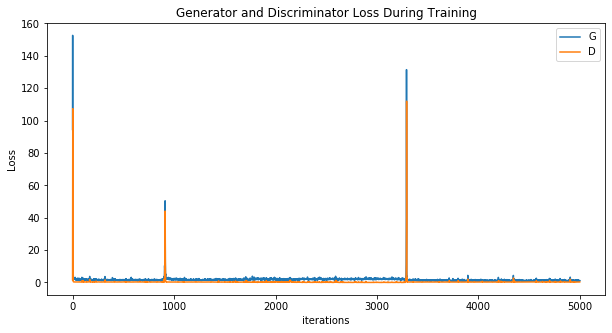

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
"""if __name='__main__':
    print(args.dataset)"""

"if __name='__main__':\n    print(args.dataset)"